In [386]:
import requests
with open('kaptcha.png', 'wb') as f:
    res = requests.get('http://railway.hinet.net/ImageOut.jsp')
    f.write(res.content)

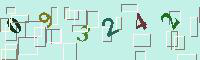

In [387]:
from PIL import Image, ImageEnhance
image = Image.open('kaptcha.png')
image

In [388]:
import cv2
import numpy
from matplotlib import pyplot as plt
im = cv2.imread('kaptcha.png', flags=cv2.IMREAD_GRAYSCALE)

In [389]:
retval, im = cv2.threshold(im, 112, 255, cv2.THRESH_BINARY_INV)

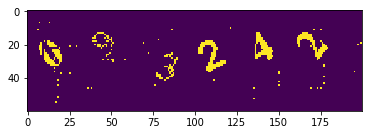

In [390]:
plt.imshow(im)

In [397]:
#im = cv2.morphologyEx(im,cv2.MORPH_OPEN,(2,2))

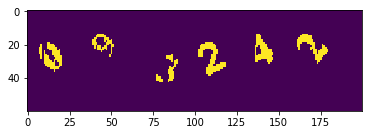

In [398]:
#plt.imshow(im)

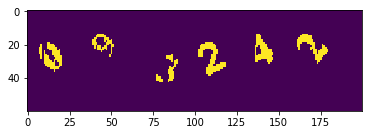

In [399]:
for i in range(len(im)):
    for j in range(len(im[i])):
        if im[i][j] == 255:
            count = 0 
            for k in range(-3, 3):
                for l in range(-2, 2):
                    try:
                        if im[i + k][j + l] == 255:
                            count += 1
                    except IndexError:
                        pass
            if count <= 3:
                im[i][j] = 0
plt.imshow(im)

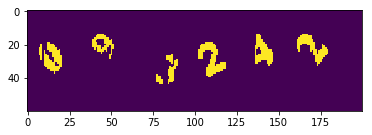

In [400]:
im = cv2.dilate(im, (2, 2), iterations=1)
plt.imshow(im)

In [401]:
image, contours, hierarchy = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in contours], key=lambda x:x[1])

arr = []

for index, (c, _) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    #print (x, y, w, h)
    try:
        # 只將寬高大於 10 視為數字留存
        if w > 10 and h > 10:
            add = True
            for i in range(0, len(arr)):
                # 這邊是要防止如 0、9 等，可能會偵測出兩個點，當兩點過於接近需忽略
                if abs(cnts[index][1] - arr[i][0]) <= 3:
                    add = False
                    break
            if add:
                arr.append((x, y, w, h))
                print (x, y, w, h)
    except IndexError:
        pass

10 19 11 19
39 14 13 15
102 19 17 21
136 14 11 19
161 14 19 19


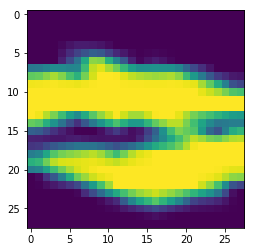

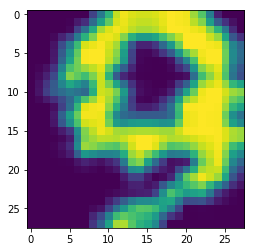

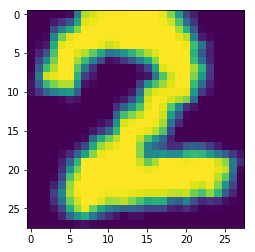

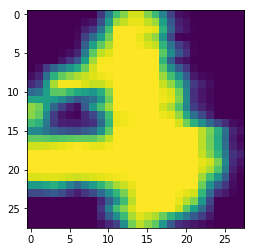

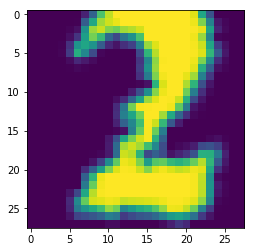

In [402]:
import time
for index, (x, y, w, h) in enumerate(arr):
    roi = im[y: y + h, x: x + w]
    thresh = roi.copy() 
    
    angle = 0
    smallest = 999
    row, col = thresh.shape

    for ang in range(-60, 61):
        M = cv2.getRotationMatrix2D((col / 2, row / 2), ang, 1)
        t = cv2.warpAffine(thresh.copy(), M, (col, row))

        r, c = t.shape
        right = 0
        left = 999

        for i in range(r):
            for j in range(c):
                if t[i][j] == 255 and left > j:
                    left = j
                if t[i][j] == 255 and right < j:
                    right = j

        if abs(right - left) <= smallest:
            smallest = abs(right - left)
            angle = ang

    M = cv2.getRotationMatrix2D((col / 2, row / 2), angle, 1)
    thresh = cv2.warpAffine(thresh, M, (col, row))
    # resize 成相同大小以利後續辨識
    thresh = cv2.resize(thresh, (28, 28))
    plt.imshow(thresh)
    plt.show()
    cv2.imwrite('D:\\Nick\\imag\\' + str(index) + time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.png', thresh)